In [7]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']= 160

In [9]:
# Filter Used to differentiate noisy data, https://github.com/stur86/tvregdiff
# Rick Chartrand, "Numerical differentiation of noisy, nonsmooth data," ISRN Applied Mathematics, Vol. 2011, Article ID 164564, 2011.

import sys
from scipy import sparse
from scipy.sparse import linalg as splin

_has_matplotlib = True

# Utility function.

def chop(v):
    return v[1:]


def TVRegDiff(data, itern, alph, u0=None, scale='small', ep=1e-6, dx=None,
              plotflag=_has_matplotlib, diagflag=1):

    # code starts here
    # Make sure we have a column vector
    data = np.array(data)
    if (len(data.shape) != 1):
        print("Error - data is not a column vector")
        return
    # Get the data size.
    n = len(data)

    # Default checking. (u0 is done separately within each method.)
    if dx is None:
        dx = 1.0 / n

    # Different methods for small- and large-scale problems.
    if (scale.lower() == 'small'):

        # Construct differentiation matrix.
        c = np.ones(n + 1) / dx
        D = sparse.spdiags([-c, c], [0, 1], n, n + 1)

        DT = D.transpose()

        # Construct antidifferentiation operator and its adjoint.
        def A(x): return chop(np.cumsum(x) - 0.5 * (x + x[0])) * dx

        def AT(w): return (sum(w) * np.ones(n + 1) -
                           np.transpose(np.concatenate(([sum(w) / 2.0],
                                                        np.cumsum(w) -
                                                        w / 2.0)))) * dx

        # Default initialization is naive derivative

        if u0 is None:
            u0 = np.concatenate(([0], np.diff(data), [0]))

        u = u0
        # Since Au( 0 ) = 0, we need to adjust.
        ofst = data[0]
        # Precompute.
        ATb = AT(ofst - data)        # input: size n

        # Main loop.
        for ii in range(1, itern+1):
            # Diagonal matrix of weights, for linearizing E-L equation.
            Q = sparse.spdiags(1. / (np.sqrt((D * u)**2 + ep)), 0, n, n)
            # Linearized diffusion matrix, also approximation of Hessian.
            L = dx * DT * Q * D

            # Gradient of functional.
            g = AT(A(u)) + ATb + alph * L * u

            # Prepare to solve linear equation.
            tol = 1e-4
            maxit = 100
            # Simple preconditioner.
            P = alph * sparse.spdiags(L.diagonal() + 1, 0, n + 1, n + 1)

            def linop(v): return (alph * L * v + AT(A(v)))
            linop = splin.LinearOperator((n + 1, n + 1), linop)

            if diagflag:
                [s, info_i] = sparse.linalg.cg(
                    linop, g, x0=None, tol=tol, maxiter=maxit, callback=None,
                    M=P)
                print('iteration {0:4d}: relative change = {1:.3e}, '
                      'gradient norm = {2:.3e}\n'.format(ii,
                                                         np.linalg.norm(
                                                             s[0]) /
                                                         np.linalg.norm(u),
                                                         np.linalg.norm(g)))
                if (info_i > 0):
                    print("WARNING - convergence to tolerance not achieved!")
                elif (info_i < 0):
                    print("WARNING - illegal input or breakdown")
            else:
                [s, info_i] = sparse.linalg.cg(
                    linop, g, x0=None, tol=tol, maxiter=maxit, callback=None,
                    M=P)
            # Update solution.
            u = u - s
            # Display plot.
            if plotflag:
                plt.plot(u)
                plt.show()

    elif (scale.lower() == 'large'):

        # Construct antidifferentiation operator and its adjoint.
        def A(v): return np.cumsum(v)

        def AT(w): return (sum(w) * np.ones(len(w)) -
                           np.transpose(np.concatenate(([0.0],
                                                        np.cumsum(w[:-1])))))
        # Construct differentiation matrix.
        c = np.ones(n)
        D = sparse.spdiags([-c, c], [0, 1], n, n) / dx
        mask = np.ones((n, n))
        mask[-1, -1] = 0.0
        D = sparse.dia_matrix(D.multiply(mask))
        DT = D.transpose()
        # Since Au( 0 ) = 0, we need to adjust.
        data = data - data[0]
        # Default initialization is naive derivative.
        if u0 is None:
            u0 = np.concatenate(([0], np.diff(data)))
        u = u0
        # Precompute.
        ATd = AT(data)

        # Main loop.
        for ii in range(1, itern + 1):
            # Diagonal matrix of weights, for linearizing E-L equation.
            Q = sparse.spdiags(1. / np.sqrt((D*u)**2.0 + ep), 0, n, n)
            # Linearized diffusion matrix, also approximation of Hessian.
            L = DT*Q*D
            # Gradient of functional.
            g = AT(A(u)) - ATd
            g = g + alph * L * u
            # Build preconditioner.
            c = np.cumsum(range(n, 0, -1))
            B = alph * L + sparse.spdiags(c[::-1], 0, n, n)
            # droptol = 1.0e-2
            R = sparse.dia_matrix(np.linalg.cholesky(B.todense()))
            # Prepare to solve linear equation.
            tol = 1.0e-4
            maxit = 100

            def linop(v): return (alph * L * v + AT(A(v)))
            linop = splin.LinearOperator((n, n), linop)

            if diagflag:
                [s, info_i] = sparse.linalg.cg(
                    linop, -g, x0=None, tol=tol, maxiter=maxit, callback=None,
                    M=np.dot(R.transpose(), R))
                print('iteration {0:4d}: relative change = {1:.3e}, '
                      'gradient norm = {2:.3e}\n'.format(ii,
                                                         np.linalg.norm(s[0]) /
                                                         np.linalg.norm(u),
                                                         np.linalg.norm(g)))
                if (info_i > 0):
                    print("WARNING - convergence to tolerance not achieved!")
                elif (info_i < 0):
                    print("WARNING - illegal input or breakdown")

            else:
                [s, info_i] = sparse.linalg.cg(
                    linop, -g, x0=None, tol=tol, maxiter=maxit, callback=None,
                    M=np.dot(R.transpose(), R))
            # Update current solution
            u = u + s
            # Display plot.
            if plotflag:
                plt.plot(u/dx)
                plt.show()

        u = u/dx

    return u

# Small testing script


# if __name__ == "__main__":

#     dx = 0.05
#     x0 = np.arange(0, 2.0*np.pi, dx)

#     testf = np.sin(x0)

#     testf = testf + np.random.normal(0.0, 0.04, x0.shape)

#     deriv_sm = TVRegDiff(testf, 1, 5e-2, dx=dx,
#                          ep=1e-1, scale='small', plotflag=0)
#     deriv_lrg = TVRegDiff(testf, 100, 1e-1, dx=dx,
#                           ep=1e-2, scale='large', plotflag=0)

#     if (_has_matplotlib):
#         plt.plot(np.cos(x0), label='Analytical', c=(0,0,0))
#         plt.plot(np.gradient(testf, dx), label='numpy.gradient')
#         plt.plot(deriv_sm, label='TVRegDiff (small)')
#         plt.plot(deriv_lrg, label='TVRegDiff (large)')
#         plt.legend()
#         plt.show()

In [13]:
fan = pd.read_csv("Test_Data/09-03-19 const humidity vary fan.csv")#, index_col=0)
hum = pd.read_csv("Test_Data/09-03-19 const fan.csv")#, index_col=0)
dfs = [fan, hum]

C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Series.data is deprecated and will be removed in a future version
  import sys


iteration    1: relative change = 5.804e-02, gradient norm = 2.353e+05

iteration    1: relative change = 8.444e-03, gradient norm = 7.740e+04



C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Series.data is deprecated and will be removed in a future version
  


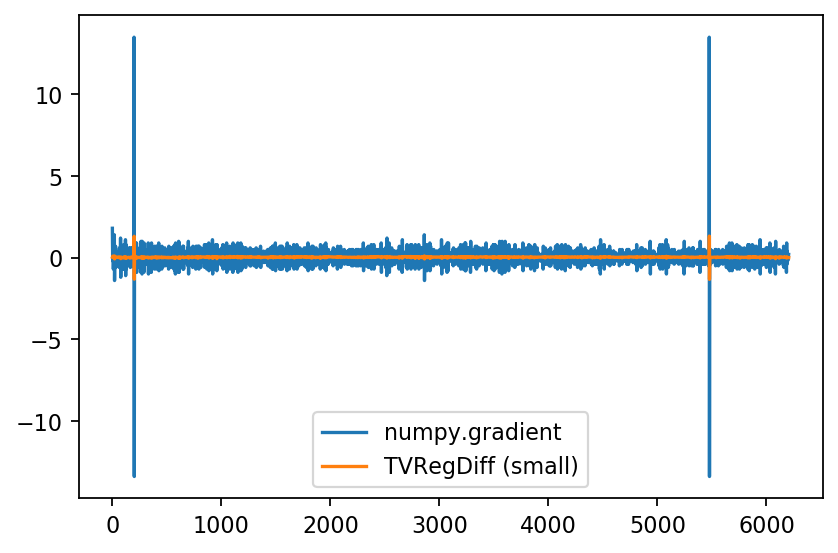

iteration    1: relative change = 1.630e-02, gradient norm = 3.830e+05

iteration    1: relative change = 5.322e-03, gradient norm = 1.495e+05



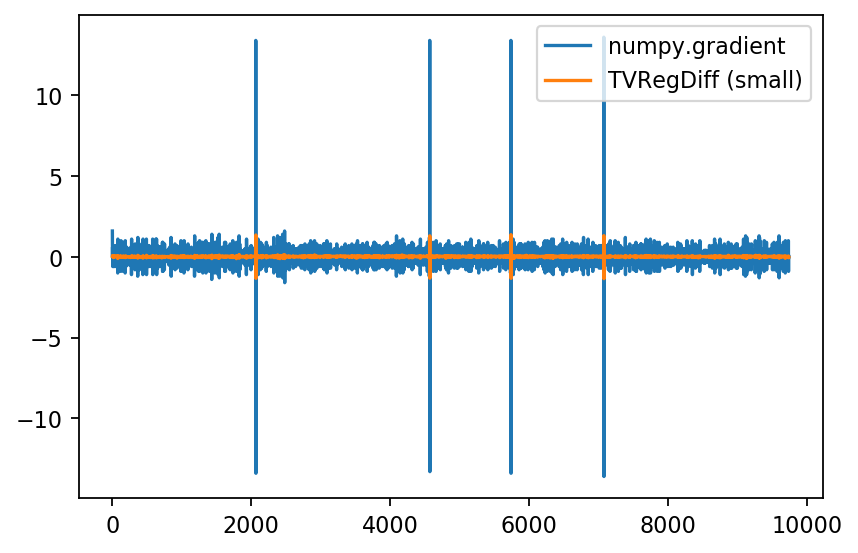

In [14]:
dx = 0.05
for df in dfs:
#     df.drop(df.index[0:250], inplace=True)
    df["Time(s)"] = df["Time"] / 1000 # Convert to Seconds
    df["Delta Humidity"] = df["Wet Humidity"] - df["Dry Humidity"]
    df["Time Interval"] = np.diff(np.concatenate(([0], df["Time(s)"])))
    deriv_sm_wet = TVRegDiff(df["Wet Humidity"].data, 1, 5e-1, dx=dx, ep=1e-1, scale='small', plotflag=0)
    deriv_sm_dry = TVRegDiff(df["Dry Humidity"].data, 1, 5e-1, dx=dx, ep=1e-1, scale='small', plotflag=0)
    df["Wet Hum Gradient"] = pd.Series(deriv_sm_wet)/df["Time Interval"]
    df["Dry Hum Gradient"] = pd.Series(deriv_sm_dry)/df["Time Interval"]
    plt.plot(np.gradient(df["Dry Humidity"], dx), label='numpy.gradient')
    plt.plot(deriv_sm_dry, label='TVRegDiff (small)')
    plt.legend()
    plt.show()
    
#     df["Wet Hum Gradient"] = np.gradient(df["Wet Humidity"])/df["Time Interval"]
#     df["Dry Hum Gradient"] = np.gradient(df["Dry Humidity"])/df["Time Interval"]
    
#     df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
fan.head(50)
# first_run.loc[first_run.index % 2 == 0,["Wet Humidity"]]

,Time,Hum,Water,Pump,SmallFan,BigFan,Wet Humidity,Dry Humidity,Wet Temperature,Dry Temperature,Wet Pressure,Dry Pressure,Time(s),Delta Humidity,Time Interval,Wet Hum Gradient,Dry Hum Gradient
750,86046,0,70,0,0,40,91.08,57.38,22.64,23.09,1015.66,1016.22,86.046,33.70,0.114,-0.272511,0.382310
751,86161,0,70,0,0,40,91.05,57.38,22.64,23.09,1015.66,1016.22,86.161,33.67,0.115,-0.196090,0.382771
752,86276,0,70,0,0,40,91.05,57.38,22.64,23.09,1015.66,1016.22,86.276,33.67,0.115,-0.025036,0.352171
753,86390,0,71,0,0,40,91.05,57.38,22.64,23.09,1015.66,1016.22,86.390,33.67,0.114,-0.051788,0.334386
754,86505,0,71,0,0,40,91.05,57.39,22.64,23.09,1015.66,1016.22,86.505,33.66,0.115,-0.107404,0.298270
755,86620,0,69,0,0,40,91.05,57.44,22.64,23.09,1015.66,1016.22,86.620,33.61,0.115,-0.101082,0.273723
756,86735,0,151,0,0,40,91.04,57.39,22.64,23.09,1015.66,1016.22,86.735,33.65,0.115,-0.113367,0.250681
757,86849,0,71,0,0,40,91.05,57.39,22.64,23.09,1015.66,1016.22,86.849,33.66,0.114,-0.047048,0.175118
758,86964,0,69,0,0,40,91.05,57.39,22.64,23.09,1015.66,1016.22,86.964,33.66,0.115,-0.029497,0.152630
759,87079,0,149,0,0,40,91.05,57.39,22.64,23.09,1015.66,1016.22,87.079,33.66,0.115,-0.028598,0.160218


In [16]:
hum.head()

,Time,Hum,Water,Pump,SmallFan,BigFan,Wet Humidity,Dry Humidity,Wet Temperature,Dry Temperature,Wet Pressure,Dry Pressure,Time(s),Delta Humidity,Time Interval,Wet Hum Gradient,Dry Hum Gradient
0,0,0,54,0,0,30,80.79,56.99,22.25,22.81,1015.76,1016.32,0.000,23.80,0.000,inf,inf
1,130,0,68,0,0,30,80.79,57.07,22.25,22.81,1015.76,1016.32,0.130,23.72,0.130,0.167048,0.393059
2,245,0,71,0,0,30,80.80,57.07,22.25,22.81,1015.76,1016.32,0.245,23.73,0.115,0.291011,0.700864
3,360,0,156,0,0,30,80.82,57.07,22.25,22.81,1015.76,1016.32,0.360,23.75,0.115,0.790187,0.690022
4,474,0,158,0,0,30,80.80,57.13,22.25,22.81,1015.76,1016.32,0.474,23.67,0.114,0.158721,0.439814


In [34]:
s = fan["Dry Hum Gradient"]
s[s > 2] = 0
s[s < -2] = 0
fan.drop(fan.index[0:250], inplace=True)

C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


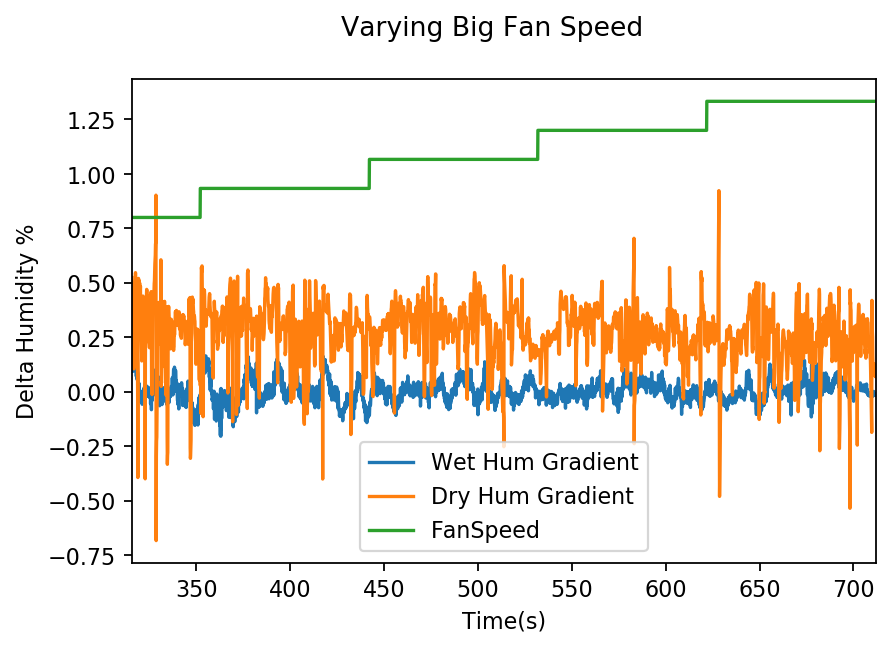

In [35]:
plt.figure().suptitle('Varying Big Fan Speed')
plt.ylabel('Delta Humidity %')
plt.xlabel('Time (s)')
fan.set_index("Time(s)")["Wet Hum Gradient"].plot(label="Wet Hum Gradient")
fan.set_index("Time(s)")["Dry Hum Gradient"].plot(label="Dry Hum Gradient")
(fan.set_index("Time(s)")["BigFan"] / 75).plot(label="FanSpeed")
plt.legend()
plt.show()

In [37]:
s1 = hum["Dry Hum Gradient"]
s1[s1 > 1] = 0
s1[s1 < -1] = 0
s2 = hum["Wet Hum Gradient"]
s2[s2 > 1] = 0
s2[s2 < -1] = 0

C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Stefa\Anaconda3\lib\site-packages\ipykernel_launcher.p

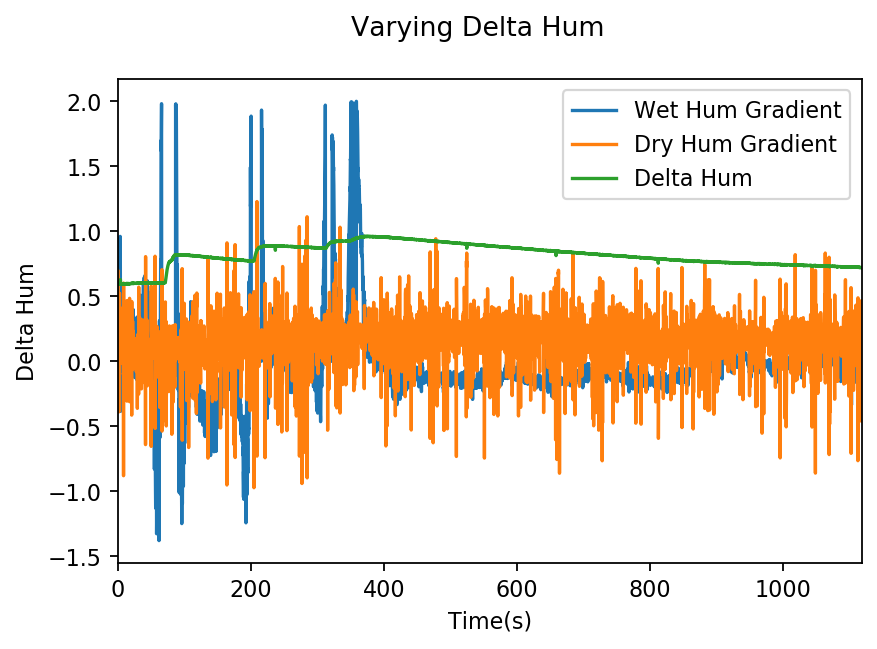

In [39]:
plt.figure().suptitle('Varying Delta Hum')
plt.ylabel('Delta Hum')
plt.xlabel('Time (s)')
hum.set_index("Time(s)")["Wet Hum Gradient"].plot(label="Wet Hum Gradient")
hum.set_index("Time(s)")["Dry Hum Gradient"].plot(label="Dry Hum Gradient")
(hum.set_index("Time(s)")["Delta Humidity"] / 40).plot(label="Delta Hum")
plt.legend()
plt.show()

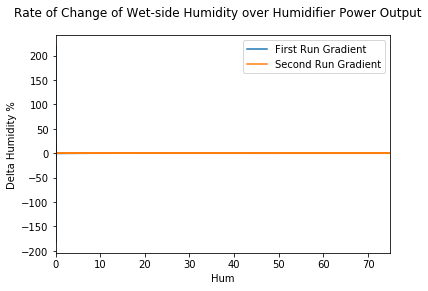

In [20]:
plt.figure().suptitle('Rate of Change of Wet-side Humidity over Humidifier Power Output')
plt.ylabel('Delta Humidity %')
plt.xlabel('Hum Speed %')
first_run.set_index("Hum")["Wet Hum Gradient"].plot(label="First Run Gradient")
second_run.set_index("Hum")["Wet Hum Gradient"].plot(label="Second Run Gradient")
plt.legend()
plt.show()

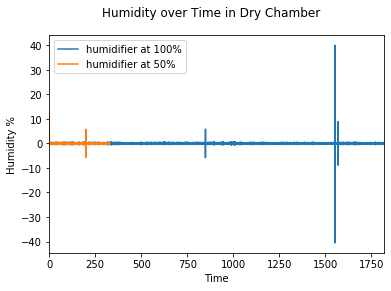

In [22]:
plt.figure().suptitle('Humidity over Time in Dry Chamber')
plt.ylabel('Humidity %')
plt.xlabel('Time (min)')
first_run.set_index("Time")["Dry Hum Gradient"].plot(label="humidifier at 100%")
second_run.set_index("Time")["Dry Hum Gradient"].plot(label="humidifier at 50%")
plt.legend()
plt.show()

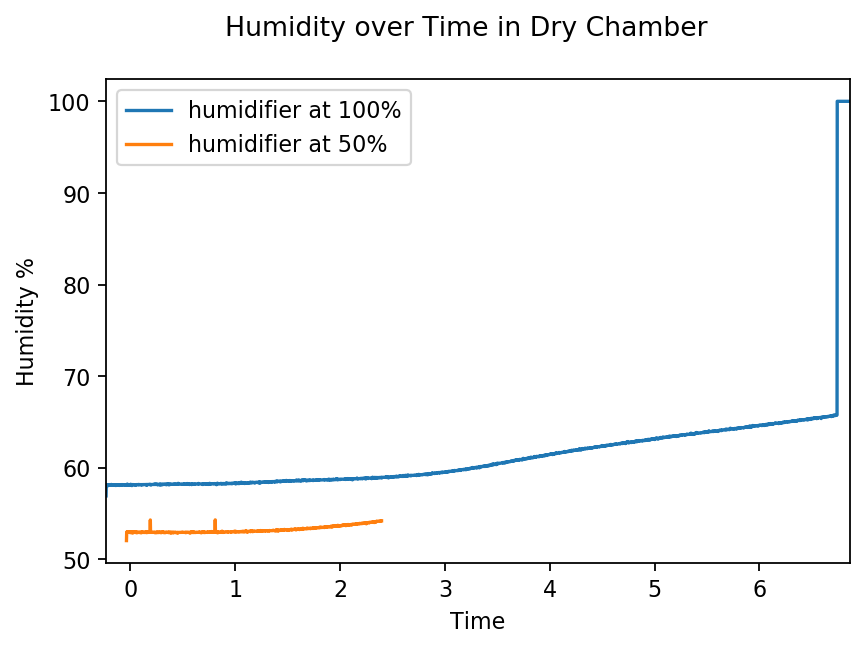

In [15]:
plt.figure().suptitle('Humidity over Time in Dry Chamber')
plt.ylabel('Humidity %')
plt.xlabel('Time (min)')
fifteen["Dry Humidity"].plot(label="humidifier at 100%")
halfhum_fifteen["Dry Humidity"].plot(label="humidifier at 50%")
plt.legend()
plt.show()